# Use `Networkit` to speed up calculations

In [1]:
import networkit as nk
import networkx as nx
import matplotlib.pyplot as plt
import random

In [11]:
def plot_powerlaw(G):
    # graph powerlaw with adapter
    hist = nx.degree_histogram(nk.nxadapter.nk2nx(nkG=G))

    plt.plot(range(0, len(hist)), hist, ".")
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("#Nodes")
    plt.loglog()
    plt.show()

# Reduce graph using `Graph Sampling` and `Edge Shedding`

## graph sampling

In [3]:
def apply_graph_sampling(G):
    # Aplicar k-core sampling usando NetworKit
    kcore = nk.centrality.CoreDecomposition(G)
    kcore.run()
    max_core = kcore.maxCoreNumber()

    # Filtrar el grafo para solo mantener nodos que pertenecen al k-core más alto
    core_nodes = [n for n in range(G.numberOfNodes()) if kcore.score(n) >= max_core]
    k_core_graph = nk.graphtools.subgraphFromNodes(G, core_nodes)

    # Mostrar estadísticas del grafo reducido
    print(
        f"Nodos originales: {G.numberOfNodes()}, Nodos reducidos: {k_core_graph.numberOfNodes()}"
    )
    print(
        f"Aristas originales: {G.numberOfEdges()}, Aristas reducidas: {k_core_graph.numberOfEdges()}"
    )
    return k_core_graph

## Edge shadding

In [24]:
def apply_edge_sheeding(G):
    # copy G
    graph = nk.Graph(G)
    # Index edges
    graph.indexEdges()
    # get edges from graph with networkit
    betweenness = nk.centrality.Betweenness(graph)
    betweenness.run()
    edge_betweenness = betweenness.edgeScores()

    iter = graph.iterEdges()
    # get edges in one line
    edges = [e for e in iter]
    # Ensure edge IDs are within range
    edges_sorted = sorted(
        edges,
        key=lambda e: (
            edge_betweenness[graph.edgeId(e[0], e[1])]
            if graph.edgeId(e[0], e[1]) < len(edge_betweenness)
            else 0
        ),
        reverse=True,
    )
    p = 0.3  # Proporción de aristas a preservar
    num_edges_to_keep = int(p * G.numberOfEdges())

    # Crear el grafo reducido
    G_reduced = nk.graph.Graph(n=graph.numberOfNodes(), weighted=False, directed=False)
    for i in range(num_edges_to_keep):
        u, v = edges_sorted[i]
        G_reduced.addEdge(u, v)

    # Mostrar estadísticas del grafo reducido
    print(f"Aristas eliminadas: {len(edges_sorted) - num_edges_to_keep}")
    print(f"Nodos: {G_reduced.numberOfNodes()}, Aristas: {G_reduced.numberOfEdges()}")
    return G_reduced

# Process data

## Read `CSV`'s and join

In [12]:
# read with networkx
filename = f"../datasets/edges/Artist-0.csv"
print(f"Reading {filename}")
G = nx.read_edgelist(
    filename,
    nodetype=str,
    delimiter=";",
    create_using=nx.DiGraph(),
)
# adapt to networkit
G = nk.nxadapter.nx2nk(G)
print(f"Nodes: {G.numberOfNodes()}, Edges: {G.numberOfEdges()}, Self Loops: {G.numberOfSelfLoops()}")

Reading ../datasets/edges/Artist-0.csv
Nodes: 20424, Edges: 631620, Self Loops: 2


In [15]:
G.removeSelfLoops()

Graph


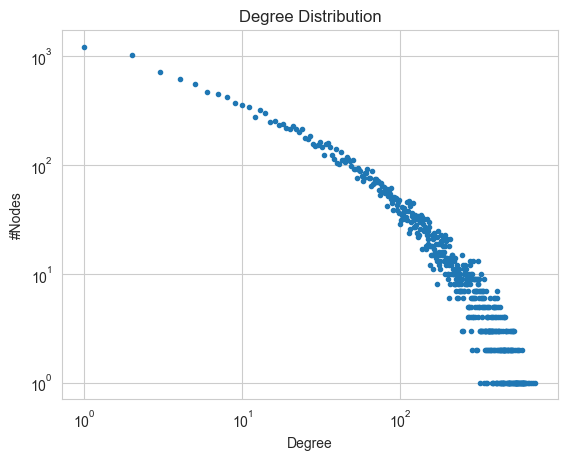

In [16]:
print("Graph")
plot_powerlaw(G)

In [ ]:
# print("Graph Sampling")
# G = apply_graph_sampling(G)
# plot_powerlaw(G)

Edge Sheeding
Aristas eliminadas: 442133
Nodos: 20424, Aristas: 189485


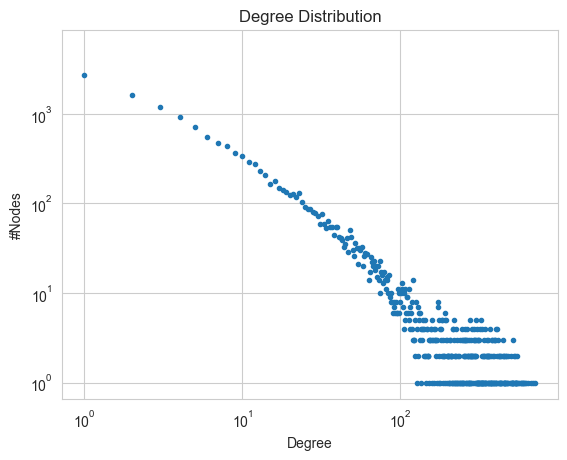

In [25]:
print("Edge Sheeding")
G = apply_edge_sheeding(G)
plot_powerlaw(G)

# Plot Graph

In [26]:
def generate_rgb(seed: int) -> str:
    # return "#xxxxx"
    random.seed(seed)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

In [37]:
g = nk.nxadapter.nk2nx(G)
nodes_size = [g.degree(node) * 1.5 for node in g.nodes()]

In [28]:
hubs, _ = nx.hits(g, max_iter=100, tol=1e-08, normalized=True)
# hubs = set(hubs.keys())

# Ordenar los nodos por sus puntajes de hub en orden descendente
sorted_hubs = sorted(hubs.items(), key=lambda item: item[1], reverse=True)

# Definir cuántos hubs principales seleccionar (ejemplo: top 3 hubs)
top_n = 10
top_hubs = sorted_hubs[:top_n]

# Mostrar los principales hubs
print(f"Top {top_n} Hubs:")
for node, score in top_hubs:
    print(f"Nodo {node}: Puntaje de hub {score}")

Top 10 Hubs:
Nodo 860: Puntaje de hub 0.0019353036245923039
Nodo 220: Puntaje de hub 0.0017655942323850447
Nodo 181: Puntaje de hub 0.0016674594999759812
Nodo 163: Puntaje de hub 0.001604593376185995
Nodo 697: Puntaje de hub 0.0015860910875653959
Nodo 1011: Puntaje de hub 0.0015788856636908537
Nodo 703: Puntaje de hub 0.0014870192739209805
Nodo 722: Puntaje de hub 0.0014781278754112453
Nodo 946: Puntaje de hub 0.0014752592538479368
Nodo 1047: Puntaje de hub 0.0014225765566229778


In [29]:
hubs = [node for node, _ in top_hubs]

In [39]:
nodes_color = [generate_rgb(100) if node in hubs else generate_rgb(120)  for node in g.nodes()]

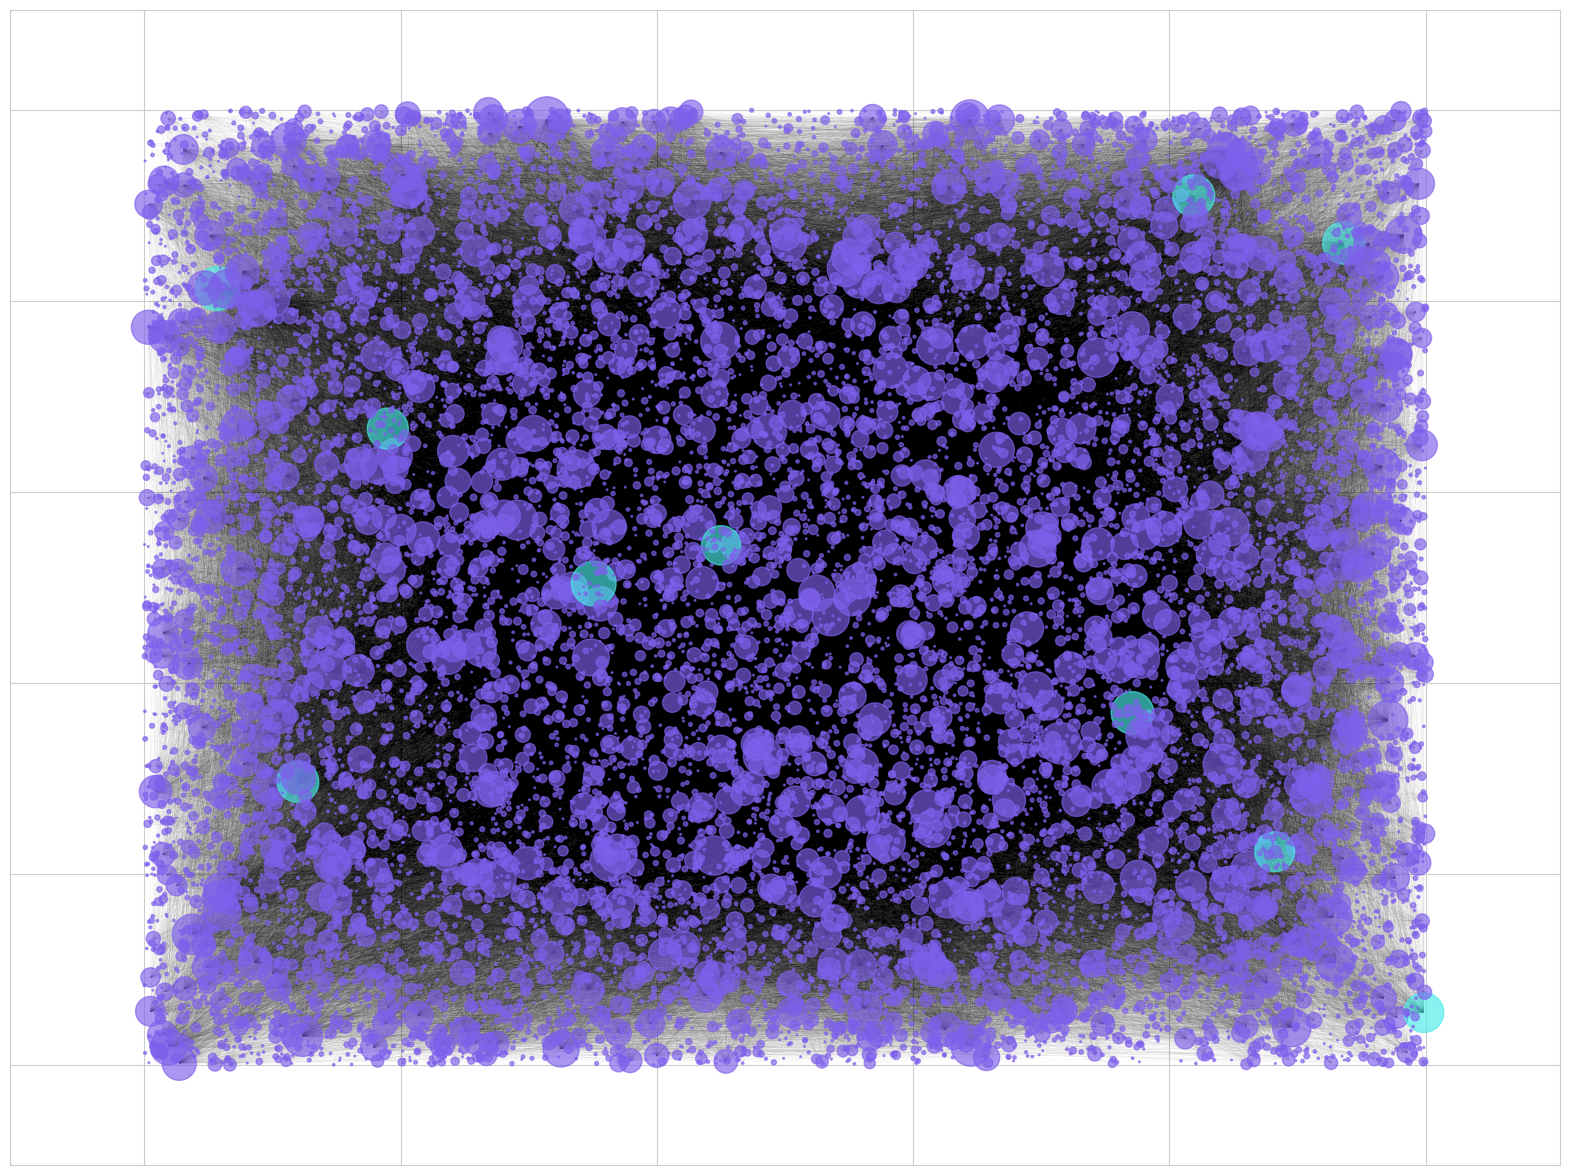

In [41]:
# Aumentar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Establecer la posición de los nodos
pos = nx.random_layout(g)

# Dibujar los nodos
nx.draw_networkx_nodes(g, pos, node_size=nodes_size, node_color=nodes_color, alpha=0.65)

# Dibujar las aristas
nx.draw_networkx_edges(g, pos, width=0.1, alpha=0.1)

# Dibujar etiquetas para los hubs
# nx.draw_networkx_labels(
#     g, pos, labels={node: node for node in hubs}, font_size=9, font_color="black"
# )

# Mostrar la gráfica
plt.show()